# TorchVision Dataset Visualization
Demonstrate ACT's TorchVision loader with MNIST/CIFAR10 perturbation visualization

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## TorchVision MNIST Perturbation Visualization

This section demonstrates:
- Loading MNIST dataset with ACT's TorchVision loader
- Creating input specifications with epsilon perturbations
- Visualizing perturbed images with model predictions
- Color-coded prediction feedback (green=correct, red=incorrect)

Loading MNIST + simple_cnn...


LOADING: MNIST + simple_cnn
[1/3] Loading dataset (test split)...
  ✓ Loaded 10000 samples
[2/3] Loading model architecture...
  ✓ Loaded custom model from simple_cnn.py
[3/3] Summary...
  Dataset: 10000 samples (test split)
  Model: 25,710,922 parameters (25,710,922 trainable)
  Batch size: 1
  Preprocessing: Yes

✓ LOADED SUCCESSFULLY

LOADING: MNIST + simple_cnn
[1/3] Loading dataset (test split)...
  ✓ Loaded 10000 samples
[2/3] Loading model architecture...
  ✓ Loaded custom model from simple_cnn.py
[3/3] Summary...
  Dataset: 10000 samples (test split)
  Model: 25,710,922 parameters (25,710,922 trainable)
  Batch size: 1
  Preprocessing: Yes

✓ LOADED SUCCESSFULLY

LOADING: MNIST + simple_cnn
[1/3] Loading dataset (test split)...
  ✓ Loaded 10000 samples
[2/3] Loading model architecture...
  ✓ Loaded custom model from simple_cnn.py
[3/3] Summary...
  Dataset: 10000 samples (test split)
  Model: 25,710,922 parameters (25,710,922 trainable)
  Batch s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


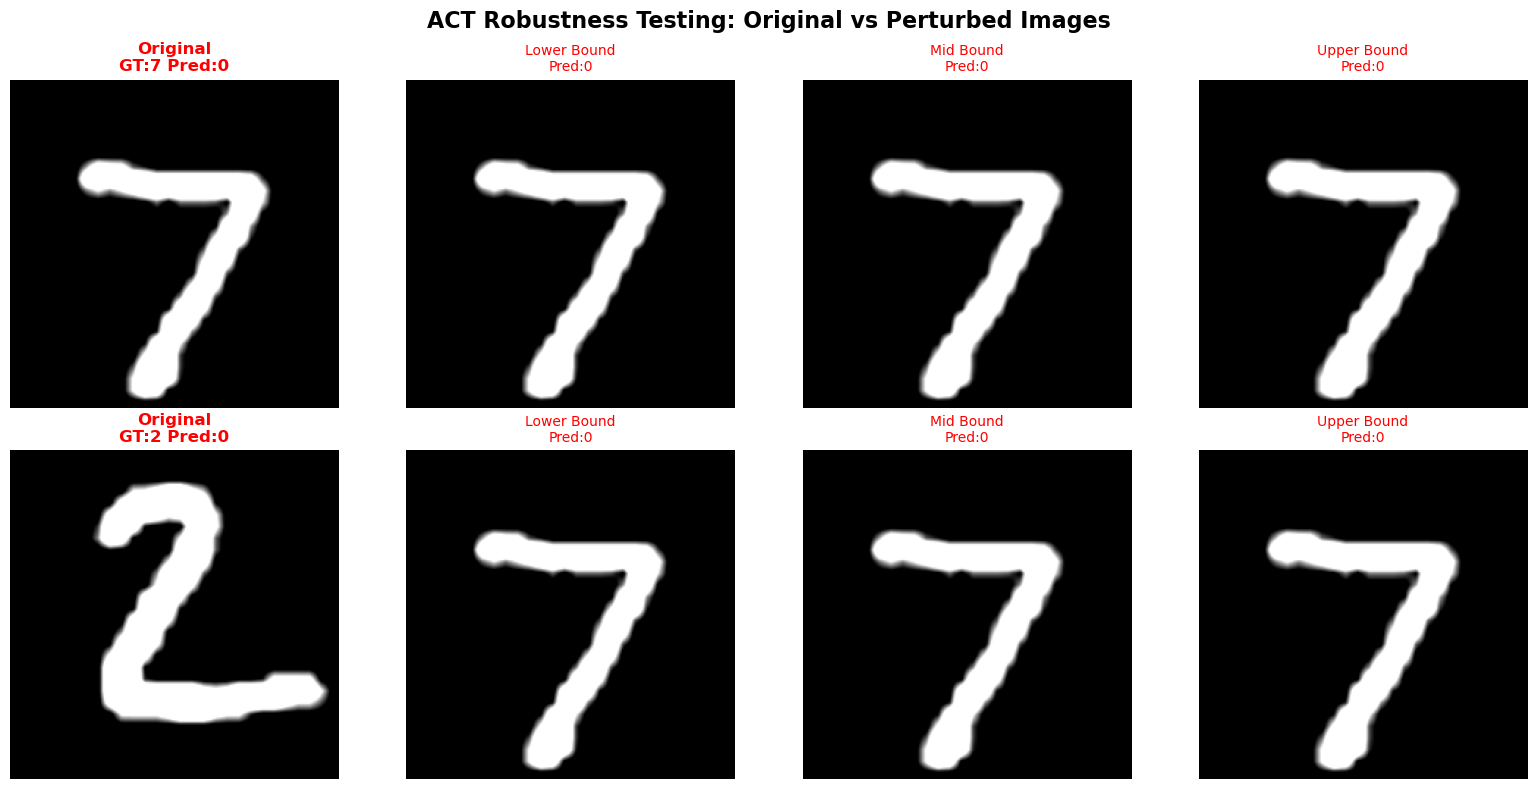


✓ Tested 2 samples with ε=0.05
  Each sample: 1 original + 3 perturbed versions
  Green = Correct prediction | Red = Incorrect prediction
  Spec type: BOX (Box constraints)


In [1]:
# ACT MNIST: Visualize Specs and Test Robustness
import sys
import os

# Setup ACT paths using path_config
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if act_root not in sys.path:
    sys.path.insert(0, act_root)

import torch
import matplotlib.pyplot as plt
import numpy as np
from act.front_end.torchvision_loader.data_model_loader import load_dataset_model_pair
from act.front_end.torchvision_loader.create_specs import TorchVisionSpecCreator
from act.front_end.specs import InKind

# Load MNIST + simple_cnn
print("Loading MNIST + simple_cnn...\n")
pair = load_dataset_model_pair("MNIST", "simple_cnn", split="test", batch_size=1, shuffle=False)
model, dataset = pair['model'], pair['dataset']
model.eval()

# Create spec creator with epsilon=0.05 for visible perturbations
spec_creator = TorchVisionSpecCreator(config_dict={
    'epsilons': [0.05],
    'input_kinds': ['BOX'],
    'output_kinds': ['MARGIN_ROBUST']
})

# Generate specs for 2 samples
results = spec_creator.create_specs_for_data_model_pairs(
    dataset_names=["MNIST"], model_names=["simple_cnn"], 
    num_samples=2, start_index=0, split="test", validate_shapes=False
)

_, _, _, input_tensors, spec_pairs = results[0]

# Visualize: Original + 3 Perturbed versions per image
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('ACT Robustness Testing: Original vs Perturbed Images', fontsize=16, fontweight='bold')

for sample_idx in range(2):
    img_tensor = input_tensors[sample_idx]
    _, label = dataset[sample_idx]
    
    # Original image - handle both grayscale and RGB
    img_np = img_tensor.numpy()
    if img_np.ndim == 3:  # (C, H, W) format
        if img_np.shape[0] == 1:  # Grayscale
            img_display = img_np.squeeze()
            cmap = 'gray'
        else:  # RGB - transpose to (H, W, C)
            img_display = np.transpose(img_np, (1, 2, 0))
            cmap = None
    else:  # Already (H, W)
        img_display = img_np
        cmap = 'gray'
    
    axes[sample_idx, 0].imshow(img_display, cmap=cmap, vmin=0, vmax=1)
    
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0)).argmax(dim=1).item()
    color = 'green' if pred == label else 'red'
    axes[sample_idx, 0].set_title(f'Original\nGT:{label} Pred:{pred}', fontweight='bold', color=color)
    axes[sample_idx, 0].axis('off')
    
    # Get spec for this sample
    input_spec = spec_pairs[sample_idx][0]
    lb, ub = input_spec.lb.numpy().squeeze(), input_spec.ub.numpy().squeeze()
    
    # Detect image shape from original tensor
    if img_np.ndim == 3:
        img_shape = img_np.shape  # (C, H, W)
    else:
        img_shape = (1, *img_np.shape)  # (1, H, W)
    
    # Generate 3 perturbed samples: lower bound, center, upper bound
    perturbed_samples = [
        lb,  # Lower bound
        (lb + ub) / 2,  # Mid-point
        ub   # Upper bound
    ]
    
    for pert_idx, pert_img in enumerate(perturbed_samples):
        # Run inference on perturbed image
        pert_tensor = torch.from_numpy(pert_img).float().unsqueeze(0)
        with torch.no_grad():
            pert_pred = model(pert_tensor).argmax(dim=1).item()
        
        # Visualize - reshape to original image shape
        pert_reshaped = pert_img.reshape(img_shape)
        if pert_reshaped.ndim == 3:
            if pert_reshaped.shape[0] == 1:  # Grayscale
                pert_display = pert_reshaped.squeeze()
                pert_cmap = 'gray'
            else:  # RGB
                pert_display = np.transpose(pert_reshaped, (1, 2, 0))
                pert_cmap = None
        else:
            pert_display = pert_reshaped
            pert_cmap = 'gray'
        
        axes[sample_idx, pert_idx + 1].imshow(pert_display, cmap=pert_cmap, vmin=0, vmax=1)
        pert_color = 'green' if pert_pred == label else 'red'
        pert_names = ['Lower', 'Mid', 'Upper']
        axes[sample_idx, pert_idx + 1].set_title(
            f'{pert_names[pert_idx]} Bound\nPred:{pert_pred}',
            color=pert_color, fontsize=10
        )
        axes[sample_idx, pert_idx + 1].axis('off')

plt.tight_layout()
plt.show()

# Summary
eps = spec_creator.config['epsilons'][0]
spec_kind = spec_pairs[0][0].kind
spec_kind_name = spec_kind.name if hasattr(spec_kind, 'name') else str(spec_kind)
print(f"\n✓ Tested {len(input_tensors)} samples with ε={eps}")
print(f"  Each sample: 1 original + 3 perturbed versions")
print(f"  Green = Correct prediction | Red = Incorrect prediction")
print(f"  Spec type: {spec_kind_name} (Box constraints)")

## Creating Custom Verification Bounds

Tutorial on creating L∞ perturbation bounds for verification tasks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].


Example: MNIST L∞ Perturbation
✓ Dataset returns: (image, label) tuple
✓ Image: MNIST test sample 5
✓ Ground Truth Label: 1 (explicit integer)
✓ Epsilon (L∞): 0.05
  Original image shape: torch.Size([3, 224, 224])
  Original image range: [-0.424, 2.809]
  Lower bounds range: [0.000, 1.000]
  Upper bounds range: [0.000, 1.000]
  Input dimension: 150528


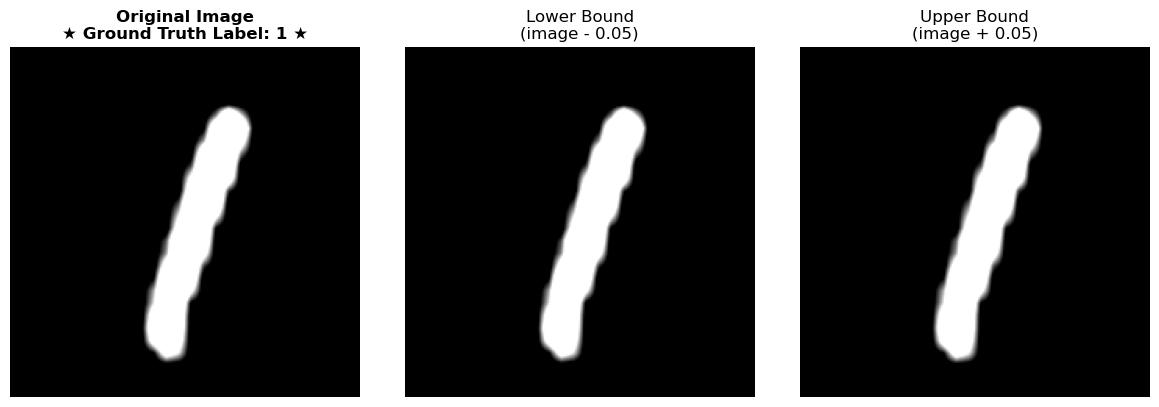


Summary: TorchVision Approach

✓ **LABELS ARE EXPLICIT**: Each dataset item is a (image, label) tuple
  - mnist_img, mnist_label = dataset[0]
  - The label is an integer (0-9 for MNIST/CIFAR10)
  - No ambiguity, no parsing needed!

✓ **BOUNDS ARE USER-DEFINED**: You create them based on verification goals
  - L∞ ball with ε = 0.01 to 0.1 (common: 0.03 for MNIST, 2/255 for CIFAR10)
  - Apply before or after normalization (depends on network)
  - Always clip to valid pixel range [0, 1]

✓ **VERIFICATION PROPERTY**: Combine bounds + label for verification
  - Input spec: All images in epsilon-ball around original image
  - Output property: Model should predict the ground truth label
  - Example: "For all images within ε=0.03, model predicts digit 5"

This approach is ideal for:
  • Custom datasets and models
  • Rapid prototyping and exploration
  • Educational demonstrations
  • Flexible verification requirements



In [9]:
# Common approaches to create verification bounds for images:
#
# 1. L_infinity (L∞) perturbation: Each pixel can vary by ±ε
# 2. L2 perturbation: Total L2 distance from center ≤ ε
# 3. Box constraints: Manual per-pixel bounds
# 4. Normalized bounds: Apply after normalization (mean/std)

def create_linf_bounds(image, epsilon, pixel_range=(0, 1)):
    """
    Create L_infinity perturbation bounds around an image.
    
    Args:
        image: torch.Tensor or numpy array (H, W) or (C, H, W)
        epsilon: Maximum perturbation per pixel
        pixel_range: Valid pixel value range (min, max)
    
    Returns:
        lower_bounds, upper_bounds (numpy arrays, flattened)
    """
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    center = image.flatten()
    lower = np.clip(center - epsilon, pixel_range[0], pixel_range[1])
    upper = np.clip(center + epsilon, pixel_range[0], pixel_range[1])
    
    return lower, upper


# Example: MNIST with L_infinity perturbation
print("="*70)
print("Example: MNIST L∞ Perturbation")
print("="*70)

mnist_img, mnist_label = dataset[5]
epsilon_mnist = 0.05

lower_mnist, upper_mnist = create_linf_bounds(mnist_img, epsilon_mnist)

print(f"✓ Dataset returns: (image, label) tuple")
print(f"✓ Image: MNIST test sample 5")
print(f"✓ Ground Truth Label: {mnist_label} (explicit integer)")
print(f"✓ Epsilon (L∞): {epsilon_mnist}")
print(f"  Original image shape: {mnist_img.shape}")
print(f"  Original image range: [{mnist_img.min():.3f}, {mnist_img.max():.3f}]")
print(f"  Lower bounds range: [{lower_mnist.min():.3f}, {lower_mnist.max():.3f}]")
print(f"  Upper bounds range: [{upper_mnist.min():.3f}, {upper_mnist.max():.3f}]")
print(f"  Input dimension: {len(lower_mnist)}")

# Visualize - handle both grayscale and RGB images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original image
img_np = mnist_img.numpy() if isinstance(mnist_img, torch.Tensor) else mnist_img
if img_np.ndim == 3:  # (C, H, W) format
    if img_np.shape[0] == 1:  # Grayscale
        img_display = img_np.squeeze()
        cmap = 'gray'
        img_shape = img_np.shape
    else:  # RGB - transpose to (H, W, C)
        img_display = np.transpose(img_np, (1, 2, 0))
        cmap = None
        img_shape = img_np.shape
else:  # Already (H, W)
    img_display = img_np
    cmap = 'gray'
    img_shape = (1, *img_np.shape)

axes[0].imshow(img_display, cmap=cmap, vmin=0, vmax=1)
axes[0].set_title(f'Original Image\n★ Ground Truth Label: {mnist_label} ★', fontweight='bold')
axes[0].axis('off')

# Lower bound
lower_reshaped = lower_mnist.reshape(img_shape)
if lower_reshaped.ndim == 3 and lower_reshaped.shape[0] > 1:
    lower_display = np.transpose(lower_reshaped, (1, 2, 0))
else:
    lower_display = lower_reshaped.squeeze()

axes[1].imshow(lower_display, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title(f'Lower Bound\n(image - {epsilon_mnist})')
axes[1].axis('off')

# Upper bound
upper_reshaped = upper_mnist.reshape(img_shape)
if upper_reshaped.ndim == 3 and upper_reshaped.shape[0] > 1:
    upper_display = np.transpose(upper_reshaped, (1, 2, 0))
else:
    upper_display = upper_reshaped.squeeze()

axes[2].imshow(upper_display, cmap=cmap, vmin=0, vmax=1)
axes[2].set_title(f'Upper Bound\n(image + {epsilon_mnist})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Summary: TorchVision Approach")
print("="*70)
print("""
✓ **LABELS ARE EXPLICIT**: Each dataset item is a (image, label) tuple
  - mnist_img, mnist_label = dataset[0]
  - The label is an integer (0-9 for MNIST/CIFAR10)
  - No ambiguity, no parsing needed!

✓ **BOUNDS ARE USER-DEFINED**: You create them based on verification goals
  - L∞ ball with ε = 0.01 to 0.1 (common: 0.03 for MNIST, 2/255 for CIFAR10)
  - Apply before or after normalization (depends on network)
  - Always clip to valid pixel range [0, 1]

✓ **VERIFICATION PROPERTY**: Combine bounds + label for verification
  - Input spec: All images in epsilon-ball around original image
  - Output property: Model should predict the ground truth label
  - Example: "For all images within ε=0.03, model predicts digit 5"

This approach is ideal for:
  • Custom datasets and models
  • Rapid prototyping and exploration
  • Educational demonstrations
  • Flexible verification requirements
""")